# News Article Matrix Factorization

---

Unsupervised classification applied to BBC News articles.

This project derives from the Kaggle competition with the same name, found here: https://www.kaggle.com/competitions/learn-ai-bbc/overview


## Kaggle Information:

### Description:

Text documents are one of the richest sources of data for businesses.

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

Following blog has good information on how to look at the problem. https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification

### Evaluation:

The evaluation metric for this competition is Accuracy. Sample Solution FIle shows the format required for submission. The file should contain a header and have the following two columns ArticleId (from Test File) Category (one of the five categories - sport, tech, business, entertainment or politics)

### Citation: 

Bijoy Bose. (2019). BBC News Classification. Kaggle. https://kaggle.com/competitions/learn-ai-bbc

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Text Cleanup](#textclean)
  - 3.3. [Missing Data](#missingdata)
  - 3.4. [Checking for Duplicate Entries](#duplicates)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


### 1.1. Energy Load Data: <a name="loaddata"></a>

Electrical load and generation data was gathered from Pennsylvania-New Jersey-Maryland Interconnection, now called PJM, which is a regional transmission organization (RTO) that coordinates movement of electricity in 13 states and Washington, DC. 

**Data Info:**
- Detailed dataset documentation can be found at https://dataminer2.pjm.com/feed/hrl_load_metered/definition.
- Accessed and obtained on 3/28/2024.
- Ranges from 1/1/1993 to 3/27/2024.
- Hourly frequency.

- **Feature Information**
    - **Datetime Beginning UTC:** Hourly datetime in UTC.
    - **Datetime Beginning EPT:** Hourly datetime in EPT.
    - **NERC Region:** North American Electric Reliability Corporation (NERC) Regions
    - **Market Region:** Designation of utility market data belongs to.
    - **Transmission Zone:** Zone where the electricity transmission occurs. Flagged by a string of the energy company(s)' name.
    - **Load Area:** Metered electric distribution company.
    - **MW:** Electrical load measured in Megawatts (MW).
    - **Company Verified:** Indicates whether the metered load has been verified by the electric distribution company.

###### [Back to Table of Contents](#toc)

## 2. Setup <a name="setup"></a>

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
from wordcloud import WordCloud
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

###### [Back to Table of Contents](#toc)

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [2]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2


###### [Back to Table of Contents](#toc)

### 2.2. Importing the Data: <a name="dataimport"></a>

In [3]:
# Set directories
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data/'

In [4]:
# Add and sort all filenames from each folder path.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
file_path = sorted(file_path)

# Iterate through filenames and add them to dataframe.
# pd.read_csv can unzip as it goes with compression argument.
train = pd.read_csv(data_folder + '/BBC News Train.csv.gz', compression = 'gzip')
X_test = pd.read_csv(data_folder + '/BBC News Test.csv.gz', compression = 'gzip')
y_test = pd.read_csv(data_folder + '/BBC News Sample Solution.csv.gz', compression = 'gzip')

###### [Back to Table of Contents](#toc)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

In [5]:
print('Train\n####################')
display(train)
print(train.dtypes)
print('\nTest\n####################')
print(X_test.columns.to_list())
print(X_test.shape)
print(y_test.columns.to_list())
print(y_test.shape)

Train
####################


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


ArticleId     int64
Text         object
Category     object
dtype: object

Test
####################
['ArticleId', 'Text']
(735, 2)
['ArticleId', 'Category']
(735, 2)


In [6]:
# Build custom color map for consistent label visualization.
category_cmap = {'business' : '#012A36',
                 'tech' : '#D16666',
                 'politics' : '#078060',
                 'sport' : '#29274C',
                 'entertainment' : '#FFF275'}

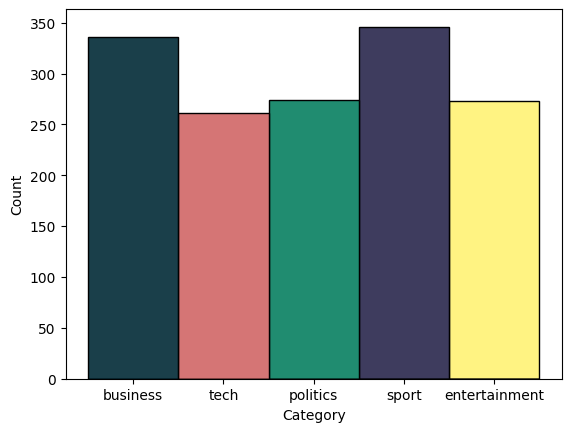

In [7]:
sns.histplot(train, x = 'Category', hue = 'Category', palette = category_cmap, legend = False, alpha = 0.9)
plt.show()

In [8]:
# Choose random text to display.
print(train.Text[25])
print(' -  -  - ')
print(train.Text[20])
print(' -  -  - ')
print(train.Text[500])

china had role in yukos split-up china lent russia $6bn (£3.2bn) to help the russian government renationalise the key yuganskneftegas unit of oil group yukos  it has been revealed.  the kremlin said on tuesday that the $6bn which russian state bank veb lent state-owned rosneft to help buy yugansk in turn came from chinese banks. the revelation came as the russian government said rosneft had signed a long-term oil supply deal with china. the deal sees rosneft receive $6bn in credits from china s cnpc.  according to russian newspaper vedomosti  these credits would be used to pay off the loans rosneft received to finance the purchase of yugansk. reports said cnpc had been offered 20% of yugansk in return for providing finance but the company opted for a long-term oil supply deal instead. analysts said one factor that might have influenced the chinese decision was the possibility of litigation from yukos  yugansk s former owner  if cnpc had become a shareholder. rosneft and veb declined to

###### [Back to Table of Contents](#toc)

### 3.2. Text Cleanup: <a name="textclean"></a>

We can see that while there looks to have been some text preprocessing already done, there are a few more steps to be taken before more exploratory data analysis can be done and then into word embedding.

**Pre-processing done already:**
1. All letters are lowercase.
2. Apostrophes have been removed (e.g. `from yukos  yugansk s former owner` and `for next week s australian open`).

However, these have only been observed from a small sample of the text, so will be checked to ensure this is the case in the entire corpus.

**Pre-processing to be done:**
1. Remove special characters.
2. Remove punctuation.
3. Remove extra spaces.
4. Remove "stop words" (e.g. `the`, `is`, `a`, `an`, `for`, etc).
5. Tokenize words (e.g. `amazingly few discotheques provide jukeboxes` $\rightarrow$ `[amazingly], [few], [discotheques], [provide], [jukeboxes]`).

**Optional Pre-processing (to be determined during model fine-tuning):**
1. Lammatize words, reducing words to their roots (e.g. `striking` $\rightarrow$ `strike` or `strikes` $\rightarrow$ `strike`).

*Note: As this project is intended for classification using matrix factorization, removing stop words, plurals, and punctuation poses little risk in negatively affecting the model's abilities. However, if semantics or other NLP applications were intended, much of sentence meaning can be lost without careful application of these techniques. Arguably, though, including special characters such as "$" could increase accuracy in classifying certain categories.*

In [9]:
def clean_corpus(df, column):
    # Remove hyphens and replace with space.
    df['hyphen'] = df[column].apply(lambda x: re.sub(r'-', ' ', x))
    # Remove anything that isn't a latter, number, or space.
    df['alpha_only'] = df['hyphen'].apply(lambda x: re.sub(r'[^ a-zA-Z0-9]+', '', x))
    # Remove any extra spaces.
    df['extra_spaces'] = df['alpha_only'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))
    # Remove stop words.
    stops = set(stopwords.words('english')) # Set lookup is faster.
    df['cleaned'] = df['extra_spaces'].apply(lambda x: ' '.join([word for word in x.split() if word not in stops]))
    
    return

In [10]:
clean_corpus(train, 'Text')
clean_corpus(X_test, 'Text')

In [11]:
print('Processed:', train.cleaned[25])
print('Original: ', train.Text[25])
print(' -  -  - ')
print('Processed:', train.cleaned[20])
print('Original: ', train.Text[20])
print(' -  -  - ')
print('Processed:', train.cleaned[500])
print('Original: ', train.Text[500])
print(' -  -  - \n -  -  - ')
print('Set Difference Example:', set(train.Text[25].split()) - set(train.cleaned[25].split()))

Processed: china role yukos split china lent russia 6bn 32bn help russian government renationalise key yuganskneftegas unit oil group yukos revealed kremlin said tuesday 6bn russian state bank veb lent state owned rosneft help buy yugansk turn came chinese banks revelation came russian government said rosneft signed long term oil supply deal china deal sees rosneft receive 6bn credits china cnpc according russian newspaper vedomosti credits would used pay loans rosneft received finance purchase yugansk reports said cnpc offered 20 yugansk return providing finance company opted long term oil supply deal instead analysts said one factor might influenced chinese decision possibility litigation yukos yugansk former owner cnpc become shareholder rosneft veb declined comment two companies rosneft cnpc agreed pre payment long term deliveries said russian oil official sergei oganesyan nothing unusual pre payment five six years announcements help explain rosneft medium sized indebted relatively

In [12]:
def tokenizer(df):
    df['tokens'] = df['cleaned'].apply(lambda x: x.split())
    
    return

In [13]:
tokenizer(train)
print(train.tokens[25])
train.tokens[train.tokens.apply(lambda x: 'china' in x)]

['china', 'role', 'yukos', 'split', 'china', 'lent', 'russia', '6bn', '32bn', 'help', 'russian', 'government', 'renationalise', 'key', 'yuganskneftegas', 'unit', 'oil', 'group', 'yukos', 'revealed', 'kremlin', 'said', 'tuesday', '6bn', 'russian', 'state', 'bank', 'veb', 'lent', 'state', 'owned', 'rosneft', 'help', 'buy', 'yugansk', 'turn', 'came', 'chinese', 'banks', 'revelation', 'came', 'russian', 'government', 'said', 'rosneft', 'signed', 'long', 'term', 'oil', 'supply', 'deal', 'china', 'deal', 'sees', 'rosneft', 'receive', '6bn', 'credits', 'china', 'cnpc', 'according', 'russian', 'newspaper', 'vedomosti', 'credits', 'would', 'used', 'pay', 'loans', 'rosneft', 'received', 'finance', 'purchase', 'yugansk', 'reports', 'said', 'cnpc', 'offered', '20', 'yugansk', 'return', 'providing', 'finance', 'company', 'opted', 'long', 'term', 'oil', 'supply', 'deal', 'instead', 'analysts', 'said', 'one', 'factor', 'might', 'influenced', 'chinese', 'decision', 'possibility', 'litigation', 'yukos'

2       [bbc, poll, indicates, economic, gloom, citize...
17      [hantuchova, dubai, last, eight, daniela, hant...
25      [china, role, yukos, split, china, lent, russi...
32      [china, continues, rapid, growth, china, econo...
46      [china, ripe, media, explosion, asia, set, dri...
                              ...                        
1371    [gadget, growth, fuels, eco, concerns, technol...
1375    [musicians, tackle, us, red, tape, musicians, ...
1382    [yukos, seeks, court, action, sale, yukos, ret...
1417    [ticking, budget, facing, us, budget, proposal...
1461    [speech, takes, search, engines, scottish, fir...
Name: tokens, Length: 62, dtype: object

In [14]:
tokenizer(X_test)

###### [Back to Table of Contents](#toc)

### 3.3. Missing Data: <a name="missingdata"></a>

In [15]:
# Check to ensure no empty tokens.
train.tokens[train.tokens.apply(lambda x: ' ' in x)]

Series([], Name: tokens, dtype: object)

In [16]:
train.isna().sum()

ArticleId       0
Text            0
Category        0
hyphen          0
alpha_only      0
extra_spaces    0
cleaned         0
tokens          0
dtype: int64

In [17]:
display(X_test.isna().sum())
display(y_test.isna().sum())

ArticleId       0
Text            0
hyphen          0
alpha_only      0
extra_spaces    0
cleaned         0
tokens          0
dtype: int64

ArticleId    0
Category     0
dtype: int64

### 3.4. Checking for Duplicate Entries: <a name="duplicates"></a>

In [18]:
print('Duplicates Found:', train.Text.duplicated().sum())
print('DF Shape:', train.shape)

drop_idx = train[train.Text.duplicated()].index
train = train.drop(drop_idx, axis = 0)

print('Duplicates Found:', train.Text.duplicated().sum())
print('DF Shape:', train.shape)

Duplicates Found: 50
DF Shape: (1490, 8)
Duplicates Found: 0
DF Shape: (1440, 8)


###### [Back to Table of Contents](#toc)

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

In [19]:
token_freq = train.explode('tokens').groupby(['tokens'], as_index=True)['tokens'].count().reset_index(
    name = 'frequency').sort_values('frequency', ascending = False)
token_freq

,tokens,frequency
19814,said,4694
15376,mr,1896
24899,would,1652
25020,year,1485
2291,also,1366
...,...,...
17904,projection,1
2324,amaya,1
10080,fudge,1
10079,fuck,1


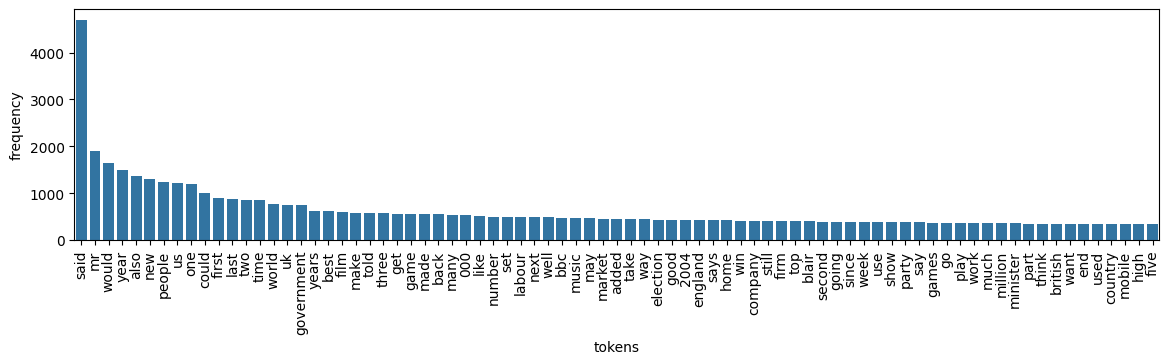

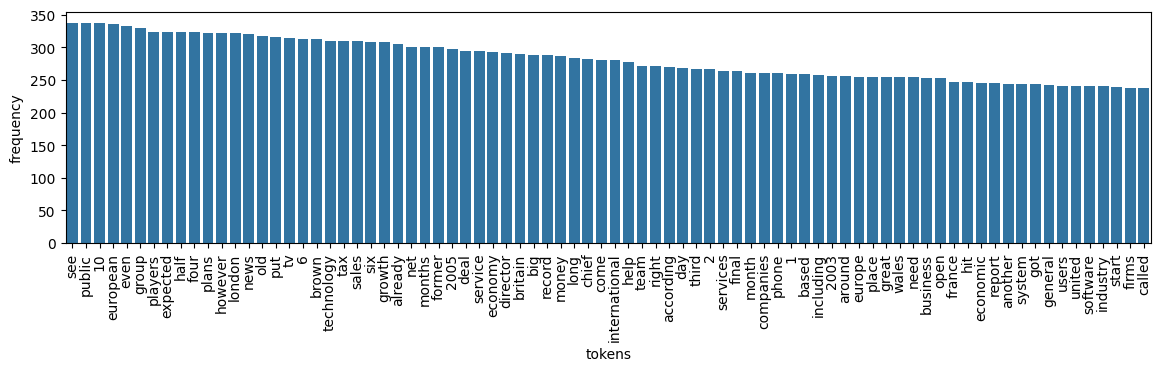

In [20]:
plt.subplots(figsize = (14, 3))
sns.barplot(token_freq[0:79], x = 'tokens', y = 'frequency')
plt.xticks(rotation = 90)
plt.show()
plt.subplots(figsize = (14, 3))
sns.barplot(token_freq[79:159], x = 'tokens', y = 'frequency')
plt.xticks(rotation = 90)
plt.show()

In [21]:
token_cat_freq = train.explode('tokens').groupby(['Category', 'tokens'], as_index=True)['tokens'].count().reset_index(name = 'frequency').sort_values('frequency', ascending = False)
token_cat_freq

,Category,tokens,frequency
26912,politics,said,1412
7902,business,said,1098
25174,politics,mr,1038
45233,tech,said,980
28748,politics,would,685
...,...,...,...
14792,entertainment,involves,1
14793,entertainment,inwhich,1
14794,entertainment,iphigenia,1
31917,sport,feint,1


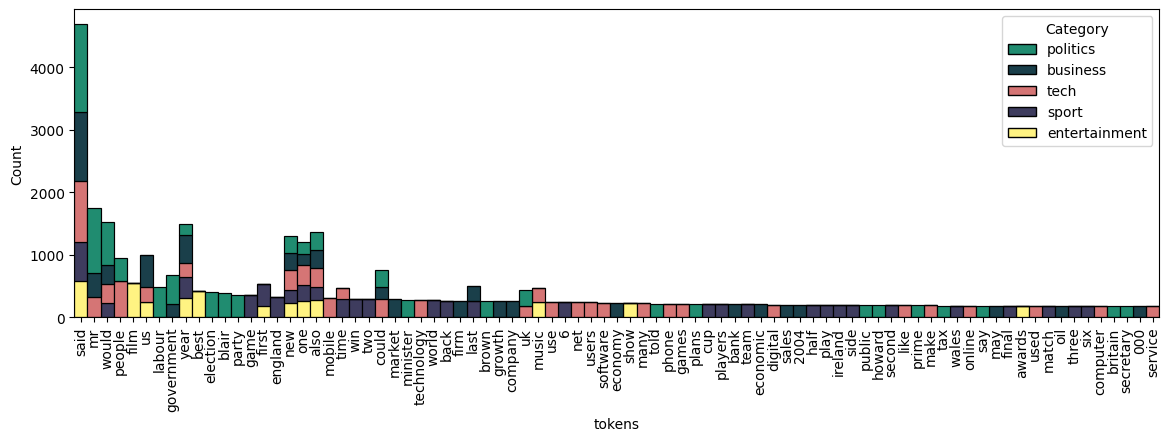

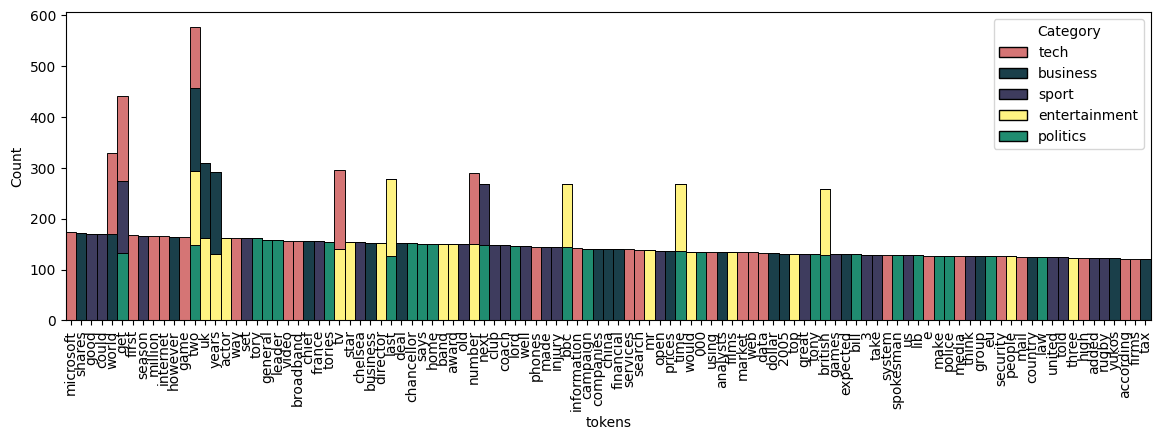

In [22]:
plt.subplots(figsize = (14, 4))
sns.histplot(token_cat_freq[0:119], x = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'Category', palette = category_cmap, alpha = 0.9)
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.show()

plt.subplots(figsize = (14, 4))
sns.histplot(token_cat_freq[119:239], x = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'Category', palette = category_cmap, alpha = 0.9)
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.show()

In [23]:
# Article lengths post tokenization.
train['article_len'] = train['tokens'].apply(lambda x: len(x))

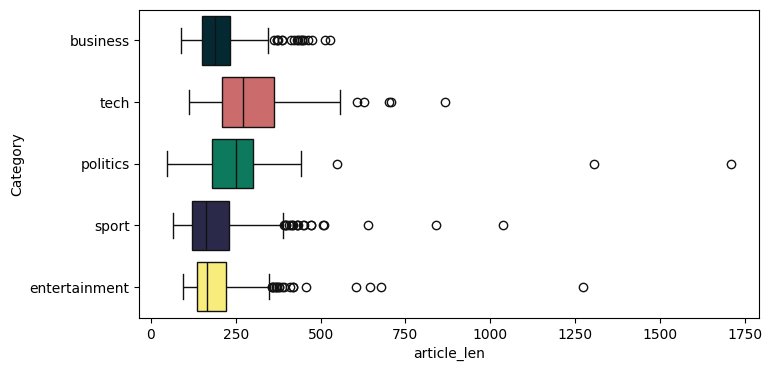

In [24]:
plt.subplots(figsize = (8, 4))
sns.boxplot(train, x = 'article_len', y = 'Category', hue = 'Category', palette = category_cmap, saturation = 0.9)
plt.show()

In [25]:
# Create gradient color maps for each category.
# Unnecessary, probably, but looks great!

n = 256
# Business
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(1/256, 1, n)
vals[:, 1] = np.linspace(42/256, 1, n)
vals[:, 2] = np.linspace(54/256, 1, n)
cmp_business = ListedColormap(vals)

# Tech
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(209/256, 1, n)
vals[:, 1] = np.linspace(102/256, 1, n)
vals[:, 2] = np.linspace(102/256, 1, n)
cmp_tech = ListedColormap(vals)

# Politics
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(3/256, 1, n)
vals[:, 1] = np.linspace(64/256, 1, n)
vals[:, 2] = np.linspace(48/256, 1, n)
cmp_politics = ListedColormap(vals)

# Sport
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(41/256, 1, n)
vals[:, 1] = np.linspace(39/256, 1, n)
vals[:, 2] = np.linspace(76/256, 1, n)
cmp_sport = ListedColormap(vals)

# Entertainment
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(161/256, 1, n)
vals[:, 1] = np.linspace(152/256, 1, n)
vals[:, 2] = np.linspace(72/256, 1, n)
cmp_entertainment = ListedColormap(vals)

# Create dictionary to call during plotting.
category_cmap_gradient = dict(zip(category_cmap.keys(), [cmp_business, cmp_tech, cmp_politics, cmp_sport, cmp_entertainment]))

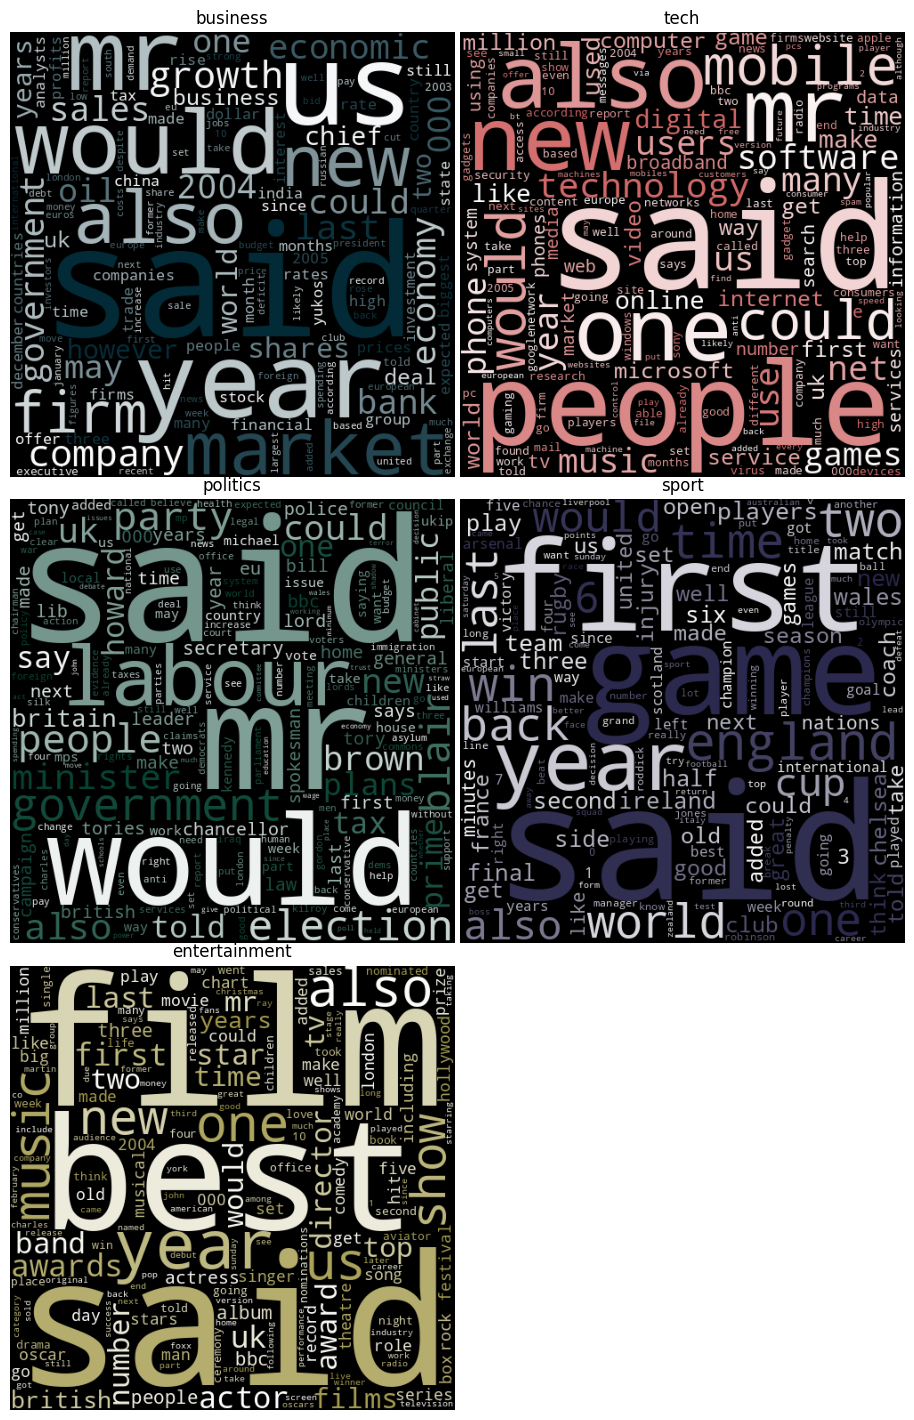

In [26]:
fig, ax = plt.subplots(3, 2, figsize = (9, 14), sharey = False, sharex = False)
for i, cat in enumerate(category_cmap.keys()):
    cloud = WordCloud(width = 500, height = 500, min_font_size = 8, colormap = category_cmap_gradient[cat]).generate_from_frequencies(
        token_cat_freq[token_cat_freq['Category'] == cat][['tokens', 'frequency']].set_index('tokens').to_dict()['frequency'])
    ax[i//2, i%2].imshow(cloud)
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title(cat)

fig.delaxes(ax[(2,1)])
plt.tight_layout(pad = 0)

## 5. Word Embedding

In [27]:
def label_permute_compare(df, y_pred, n = 5):
    """
    Parameters:
        df: dataframe containing category labels.
        y_pred: class label prediction flat array or series.
    Returns: 
        Permuted label order and accuracy score.
        Example: (0, 4, 1, 2, 3), 0.95
    """
    acc = float('-inf')
    label_order = None
    labels = {key : i for i, key in enumerate(df['Category'].unique())}
    order_perms = list(itertools.permutations(range(0, n)))

    # Iterate through order permutations.
    for i_order in order_perms:
        # Assign label dictionary new order permutation.
        for i, key in enumerate(labels.keys()):
            labels[key] = i_order[i]

        # Map new permutation to classes in DF.
        df['class_perm'] = df['Category'].map(labels)
        # Calculate accuracy for this permutation.
        # Only calculating simple accuracy, not per class.
        perm_acc = accuracy_score(y_true = df['class_perm'], y_pred = y_pred)
        # Check if this permutation accuracy is better than last best.
        if perm_acc > acc:
            acc = perm_acc
            label_order = i_order

    return (label_order, acc)

In [28]:
tfidf = TfidfVectorizer(min_df = 2, # ignore terms that have a document frequency strictly lower than the given threshold
                        max_df = 0.9, # ignore terms that have a document frequency strictly higher than the given threshold
                        norm = 'l2', 
                        stop_words = None, 
                        ngram_range = (1, 2))
train_sparse_embed = tfidf.fit_transform(train['cleaned'])
print('TF-IDF Sparse Matrix Shape:', train_sparse_embed.shape)

TF-IDF Sparse Matrix Shape: (1440, 45097)


In [29]:
# TODO: Optimize these parameters.
mod_nmf = NMF(n_components = 5, 
              init = None, 
              solver = 'mu', 
              beta_loss = 'kullback-leibler',
              tol = 0.000001,
              max_iter = 500,
              random_state = 11,
              l1_ratio = 0.4,
              verbose = 0)

mod_nmf_train = mod_nmf.fit_transform(train_sparse_embed)

print(mod_nmf_train)
print(mod_nmf_train.shape)
mod_nmf_train_y_pred = mod_nmf_train.argmax(axis = 1) # mod_nmf_train.nonzero()[1] # Some rows have more than one non-zero.

[[5.56789957e-002 4.55605682e-002 2.49393646e-086 1.32691950e-042
  1.98879054e-059]
 [1.19949258e-001 3.06374784e-076 1.19331742e-095 2.52375141e-122
  6.51209558e-091]
 [1.16327279e-001 1.21394337e-005 1.11105704e-055 2.92798768e-031
  5.09203080e-023]
 ...
 [9.95843050e-002 1.48703201e-082 1.05568167e-065 3.22919123e-075
  6.13961680e-079]
 [2.25517567e-038 3.00707742e-101 1.07347202e-065 2.31294992e-067
  1.50162880e-001]
 [2.23007398e-048 2.01181506e-103 1.85126928e-080 1.46692136e-086
  9.71810588e-002]]
(1440, 5)


In [30]:
labelorder, acc = label_permute_compare(train, mod_nmf_train_y_pred)
print(labelorder, acc)
# Map best accuracy permutation order and predictions to dataframe.
labels = {key : i for i, key in zip(labelorder, train['Category'].unique())}
train['class_perm'] = train['Category'].map(labels)
train['y_pred'] = mod_nmf_train_y_pred

(0, 4, 1, 2, 3) 0.9527777777777777


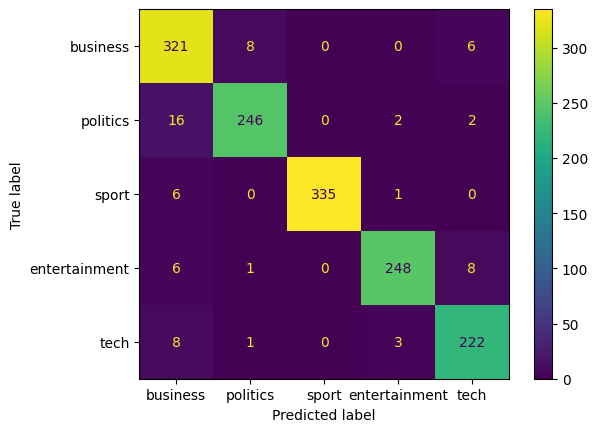

Accuracy: 0.9527777777777777


In [31]:
conf_matrix = confusion_matrix(y_true = train['class_perm'], y_pred = train['y_pred'])
# Need to sort labels by dictionary value to match new indexes given to categories.
# This is done in display_labels. A little convoluted but works for now.
ConfusionMatrixDisplay(conf_matrix, display_labels = {k: v for k, v in sorted(labels.items(), key = lambda item: item[1])}).plot()
plt.show()
print('Accuracy:', accuracy_score(y_true = train['class_perm'], y_pred = train['y_pred']))

In [34]:

def model_optimizer(param_grid):
    params_permut = list(itertools.product(*param_grid.values()))  
    print(f'The number of parameter combinations to be tested: {len(params_permut)}')

    opt_acc = float('-inf')
    opt_label_order = None
    opt_params = None

    for i, par in enumerate(params_permut):
        current_params = dict(zip(param_grid.keys(), par))
        print('Current Test:', i+1, '| Params:', current_params)
        # Handle some incompatible combinations of parameters.
        if (current_params['solver'] == 'cd') and (current_params['beta_loss'] == 'kullback-leibler'):
            continue # Skip loop
        if (current_params['solver'] == 'mu') and (current_params['init'] == 'nndsvd'):
            continue # Skip loop

        tfidf = TfidfVectorizer(min_df = current_params['min_df'], # ignore terms that have a document frequency strictly lower than the given threshold
                            max_df = current_params['max_df'], # ignore terms that have a document frequency strictly higher than the given threshold
                            norm = current_params['norm'], 
                            stop_words = None, 
                            ngram_range = current_params['ngram_range'])
        train_sparse_embed = tfidf.fit_transform(train['cleaned'])

        mod_nmf = NMF(n_components = 5, 
                    init = current_params['init'], 
                    solver = current_params['solver'], 
                    beta_loss = current_params['beta_loss'],
                    tol = 0.000001,
                    max_iter = 500,
                    random_state = 11,
                    l1_ratio = current_params['l1_ratio'],
                    verbose = 0)

        mod_nmf_train = mod_nmf.fit_transform(train_sparse_embed)
        mod_nmf_train_y_pred = mod_nmf_train.argmax(axis = 1)
        
        label_order, acc = label_permute_compare(train, mod_nmf_train_y_pred)
        # Map best accuracy permutation order and predictions to dataframe.
        labels = {key : i for i, key in zip(label_order, train['Category'].unique())}
        train['class_perm'] = train['Category'].map(labels)
        train['y_pred'] = mod_nmf_train_y_pred

        if acc > opt_acc:
            opt_acc = acc
            opt_label_order = label_order
            opt_params = current_params
            print('!!!', opt_label_order, opt_acc)

    print(f'Optimized Model:\n  Parameters - {opt_params}\n  Label Order - {opt_label_order}\n  Accuracy - {opt_acc}')
    return (opt_params, opt_label_order, opt_acc)

In [35]:
# Optimization Grid
param_grid = {'min_df' : [1,2,3,10],
              'max_df' : np.linspace(0.2,0.8,4),
              'norm' : ['l1','l2'],
              'ngram_range' : [(1,1),(1,2),(1,3)],
              'init' : ['random','nndsvd','nndsvda'],
              'solver' : ['cd','mu'],
              'beta_loss' : ['frobenius','kullback-leibler'],
              'l1_ratio' : np.linspace(0,1,6)}

opt_params, opt_label_order, opt_acc = model_optimizer(param_grid = param_grid)

The number of parameter combinations to be tested: 6912
Current Test: 1 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
!!! (3, 4, 0, 1, 2) 0.6826388888888889
Current Test: 2 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.2}
Current Test: 3 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.4}
Current Test: 4 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.6000000000000001}
Current Test: 5 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.8}
Current Test: 6 Params: {'min_df': 1, 'max_df': 0.2, 'n

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 20 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.2}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 21 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.4}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 22 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.6000000000000001}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 23 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 24 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 25 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Test: 26 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.2}
Current Test: 27 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.4}
Current Test: 28 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.6000000000000001}
Current Test: 29 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.8}
Current Test: 30 Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'froben

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 668 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.2}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 669 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.4}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 670 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.6000000000000001}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 671 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 672 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 673 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Test: 674 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.2}
Current Test: 675 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.4}
Current Test: 676 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.6000000000000001}
Current Test: 677 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.8}
Current Test: 678 Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': '

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 2900 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.2}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 2901 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.4}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 2902 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.6000000000000001}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 2903 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 2904 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 2905 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Test: 2906 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.2}
Current Test: 2907 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.4}
Current Test: 2908 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.6000000000000001}
Current Test: 2909 Params: {'min_df': 2, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.8}
Current Test: 2910 Params: {'min_df': 2, 'max_df': 0.6000000

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 3332 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.2}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 3333 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.4}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 3334 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.6000000000000001}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 3335 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 3336 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 3337 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Test: 3338 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.2}
Current Test: 3339 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.4}
Current Test: 3340 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.6000000000000001}
Current Test: 3341 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.8}
Current Test: 3342 Params: {'min_df': 2, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_lo

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 4628 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.2}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 4629 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.4}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 4630 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.6000000000000001}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 4631 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 4632 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 4633 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Test: 4634 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.2}
Current Test: 4635 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.4}
Current Test: 4636 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.6000000000000001}
Current Test: 4637 Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.8}
Current Test: 4638 Params: {'min_df': 3, 'max_df': 0.6000000

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5060 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.2}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5061 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.4}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5062 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.6000000000000001}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5063 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5064 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5065 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Test: 5066 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.2}
Current Test: 5067 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.4}
Current Test: 5068 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.6000000000000001}
Current Test: 5069 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.8}
Current Test: 5070 Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_lo

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5276 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.2}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5277 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.4}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5278 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.6000000000000001}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5279 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5280 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'random', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Test: 5281 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Test: 5282 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.2}
Current Test: 5283 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.4}
Current Test: 5284 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.6000000000000001}
Current Test: 5285 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.8}
Current Test: 5286 Params: {'min_df': 10, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'b

In [36]:
opt_acc

0.96875

In [37]:
opt_label_order

(0, 4, 3, 1, 2)

In [38]:
opt_params

{'min_df': 3,
 'max_df': 0.2,
 'norm': 'l1',
 'ngram_range': (1, 3),
 'init': 'nndsvda',
 'solver': 'mu',
 'beta_loss': 'kullback-leibler',
 'l1_ratio': 0.0}

###### [Back to Table of Contents](#toc)

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. Quick resource on stop word removal in Python - https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
2. Regex to remove extra whitespace - https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string

###### [Back to Table of Contents](#toc)